# **Fellowship.ai Challenge**

* **Name**: Anmol Pant
* **Email** : anmolpant@gmail.com
* **Region**: ASIA - IST

## Topic Chosen - ULMFiT Sentiment : Apply a supervised or semi-supervised ULMFiT model to Twitter US Airlines Sentiment 
* Environment Used for notebook - Kaggle Kernels
* Dataset Used : twitter-airline-sentiment on kaggle (https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv)
* Method used for sentiment analysis: ULMFit method (making use of RNNs and LSTMs)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-airline-sentiment/database.sqlite
/kaggle/input/twitter-airline-sentiment/Tweets.csv


## **Importing dependencies**

In [2]:
#utilities for data processing and algebra
import numpy as np 
import pandas as pd 

#for specialized container datatypes
import collections

#for plotting and data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#for feature preprocessing
import re

#sklearn for machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

#extension to reload modules before executing user code
%reload_ext autoreload
%autoreload 2

#importing os to analyse and organize the directory structure
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/twitter-airline-sentiment/database.sqlite
/kaggle/input/twitter-airline-sentiment/Tweets.csv


## **Importing fastai for Natural Language Processing and ULMFiT**

In [3]:
from fastai import *
from fastai.text import *

## **Importing utilities for collecting/checking fastai user environment**

In [4]:
import fastai.utils.collect_env
fastai.utils.collect_env.show_install()



```text
=== Software === 
python        : 3.7.6
fastai        : 1.0.61
fastprogress  : 0.2.3
torch         : 1.5.1
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 16280MB | Tesla P100-PCIE-16GB

=== Environment === 
platform      : Linux-4.19.112+-x86_64-with-debian-buster-sid
distro        : #1 SMP Sat Jun 13 11:04:33 PDT 2020
conda env     : Unknown
python        : /opt/conda/bin/python3.7
sys.path      : /kaggle/working
/kaggle/lib/kagglegym
/kaggle/lib
/opt/conda/lib/python37.zip
/opt/conda/lib/python3.7
/opt/conda/lib/python3.7/lib-dynload

/root/.local/lib/python3.7/site-packages
/opt/conda/lib/python3.7/site-packages
/src/bq-helper
/opt/conda/lib/python3.7/site-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s)

# **Data Representation and pre-processing**

In [5]:
path = Path('../input/twitter-airline-sentiment/')
file_name = 'Tweets.csv'
path.ls()

[PosixPath('../input/twitter-airline-sentiment/database.sqlite'),
 PosixPath('../input/twitter-airline-sentiment/Tweets.csv')]

## **Shuffling & reading the data into a pandas dataframe**

In [6]:
file_path = path / file_name
df_tweets = pd.read_csv(file_path)
df_tweets = df_tweets.reindex(np.random.permutation(df_tweets.index)) 
df_tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
6457,567838174816395264,negative,1.0,Can't Tell,1.0,Southwest,NaN,TRomano22,NaN,0,@SouthwestAir Not your finest moment in Boston...,NaN,2015-02-17 16:09:05 -0800,NaN,Eastern Time (US & Canada)
3263,568564485457252352,negative,1.0,longlines,1.0,United,NaN,dmb41shows,NaN,0,@united still sitting here waiting for a plane...,NaN,2015-02-19 16:15:11 -0800,Pursuit of Happiness,Hawaii
10232,569472446954389504,negative,1.0,Cancelled Flight,1.0,US Airways,NaN,JulesMonacelli,NaN,0,@USAirways not happy!! Trying to get home on C...,NaN,2015-02-22 04:23:06 -0800,"Rochester, NY",Eastern Time (US & Canada)
14481,569608733321498627,positive,1.0,NaN,NaN,American,NaN,JuliaWallClarke,NaN,0,@AmericanAir appreciate update. Have also appr...,"[40.6474324, -73.7936881]",2015-02-22 13:24:39 -0800,UK / Canada / etc,Atlantic Time (Canada)
10420,569319723889876993,negative,1.0,Cancelled Flight,1.0,US Airways,NaN,T_Hans13,NaN,0,@USAirways Bravo handling MSP to PHX # 2023 to...,NaN,2015-02-21 18:16:14 -0800,"Mabel, MN",NaN


## **analysing features and plotting relevant ones**

In [7]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14640 entries, 6457 to 6176
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13 

In [8]:
df_tweets.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


We see that the two most relevant features for us to perform sentiment analysis would be the columns 'airline_sentiment' and the 'text' that is contained in the tweet.

**Plotting the different sentiments wrt the types and the airline towards which these sentiments were directed.**

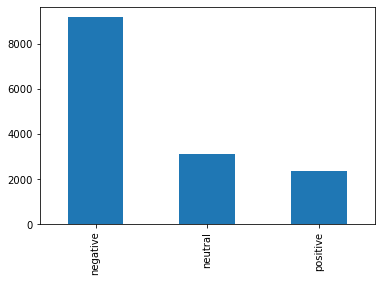

In [9]:
df_tweets['airline_sentiment'].value_counts().plot(kind='bar')

From the above graph, we can clearly see that most of the tweets in the given dataset are negative, followed by neutral. The number of positive tweets are relatively fewer in number.

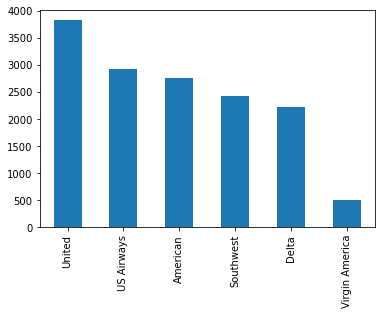

In [10]:
df_tweets['airline'].value_counts().plot(kind='bar')

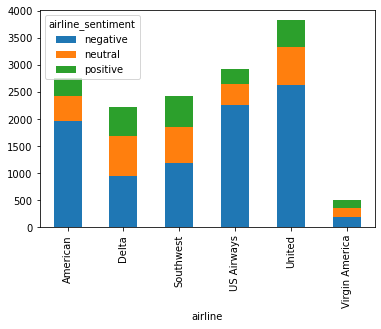

In [11]:
df_tweets.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)

**From the above two graphs we can see that there is a clear correlation between the degree of passenger satisfaction and the specific airline they were flying with, hence while feature engineering, we would have to filter out the airline name from our dataset so that our model doesn't learn it as a parameter and make it a basis for prediction.**

**Analysing the sentiment on the basis of the length of the tweet**

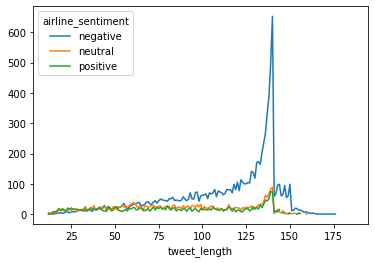

In [12]:
df_tweets['tweet_length'] = df_tweets['text'].apply(len)
df_tweets.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind='line', stacked=False)

We see that there isn't alot of correation between the tweet length and the sentiment behind the tweet. The only conclusion that can safely be drawn from the above graph is the fact that the distribution is heavily skewed in the case of negative tweets, as the more dissatisfied the passenger, the more they have to say. 

Lets check if any such conclusion can be drawn when it comes to average and median sentiment confidence as well. 

Text(0.5, 1.0, 'Average Airline Sentiment vs tweet length')

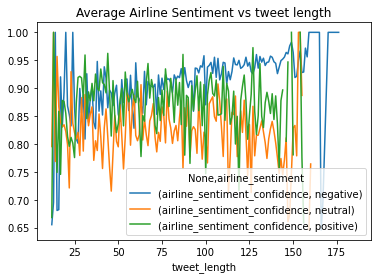

In [13]:
df_tweets[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).mean().unstack().plot(kind='line', stacked=False)
plt.title('Average Airline Sentiment vs tweet length')

Text(0.5, 1.0, 'Median Airline Sentiment vs tweet length')

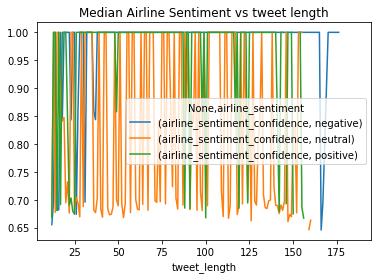

In [14]:
df_tweets[['tweet_length', 'airline_sentiment', 'airline_sentiment_confidence']].groupby(['tweet_length', 'airline_sentiment']).median().unstack().plot(kind='line', stacked=False)
plt.title('Median Airline Sentiment vs tweet length')

As no distinguishable and concrete relationship can be inferred from the confidence and tweet length, we will form a dataframe considering the text and airline_sentiment attribute.

In [15]:
features = ['airline_sentiment','text']
df_needed = df_tweets[features]
pd.set_option('display.max_colwidth', 0)
df_needed.head()

,airline_sentiment,text
6457,negative,@SouthwestAir Not your finest moment in Boston right now!
3263,negative,@united still sitting here waiting for a plane....4 hours wasted
10232,negative,@USAirways not happy!! Trying to get home on Cancelled Flighted flight&amp; been on hold for 2 hours. Help!! This is just crazy...
14481,positive,"@AmericanAir appreciate update. Have also appreciated our pilots effort to explain to us just now. Accurate, authoritative comms is vital."
10420,negative,"@USAirways Bravo handling MSP to PHX # 2023 today. Delayed, Late Flightr Cancelled Flightled. Missed surprise 60th bday which was reason for trip.Never again"


In [16]:
df_needed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14640 entries, 6457 to 6176
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  14640 non-null  object
 1   text               14640 non-null  object
dtypes: object(2)
memory usage: 343.1+ KB


In [17]:
df_needed.describe()

,airline_sentiment,text
count,14640,14640
unique,3,14427
top,negative,@united thanks
freq,9178,6


**Checking for missing values in our data**

In [18]:
df_needed.isna().sum()

airline_sentiment    0
text                 0
dtype: int64

In [19]:
#df_needed['airline_sentiment'].count()

In [20]:
df_needed['airline_sentiment'].value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

Text(0.5, 1.0, 'Airline Sentiment for each US Airline')

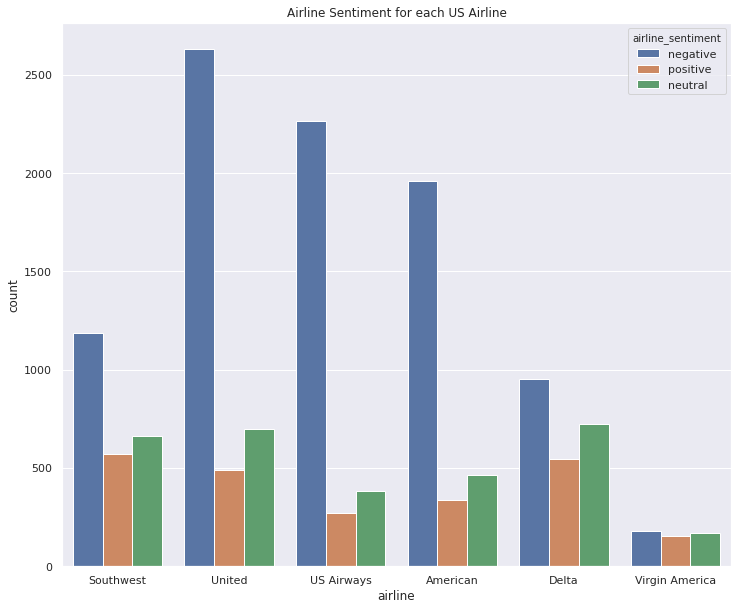

In [21]:
sns.set(style = "whitegrid")
sns.set(rc={'figure.figsize': (12,10)})
sns.countplot(x="airline", hue = 'airline_sentiment', data=df_tweets)
plt.title("Airline Sentiment for each US Airline")

### As we see that customer sentiments are somewhat specific to the airline they are using to travel, hence we will have to remove the names of the airlines so that our predictive model is not influenced by the names of the airlines because of the high correlation. 

In [22]:
reg = r"@(VirginAmerica|SouthwestAir|united|AmericanAir|Delta|USAirways)"

Writing a function to replace the airline name

In [23]:
def text_filter(text):
    return re.sub(reg,'@airline',text, flags = re.IGNORECASE)

In [24]:
df_needed['text'] = df_needed['text'].apply(text_filter)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [25]:
df_needed.head(15)

,airline_sentiment,text
6457,negative,@airline Not your finest moment in Boston right now!
3263,negative,@airline still sitting here waiting for a plane....4 hours wasted
10232,negative,@airline not happy!! Trying to get home on Cancelled Flighted flight&amp; been on hold for 2 hours. Help!! This is just crazy...
14481,positive,"@airline appreciate update. Have also appreciated our pilots effort to explain to us just now. Accurate, authoritative comms is vital."
10420,negative,"@airline Bravo handling MSP to PHX # 2023 today. Delayed, Late Flightr Cancelled Flightled. Missed surprise 60th bday which was reason for trip.Never again"
8451,negative,"@JetBlue your customer services agent Jorge at Orlando International is rude and disrespectful, I never want to deal with your bullshit ever"
13138,positive,@airline THANK YOU FOR ALL THE HELP! :P You guys are the best. #americanairlines #americanair
9057,neutral,@airline can I check bags through to my final destination even though I bought separate tickets from IAD to PHL and PHL to Israel?
89,negative,@airline Why is the site down? When will it be back up?
9829,negative,@airline ...was Cancelled Flightled and now I need to locate my baggage


We have successfully removed the airlines names from our dataframe.
Now we convert the obtained dataframe into a databunch, as required by our training method.

# ULMFiT training method

**Splitting the dataset into train and test sets, initializing hyperparameters and converting it into a Databunch**

In [26]:
train, test = train_test_split(df_needed, test_size =0.1)
moms = (0.8,0.7)
wd = 0.1

## *Tokenization*

We read in the data and add new words to our dictionary, as well as create a representation of words using numbers.

In [27]:
data = TextLMDataBunch.from_df(path, train_df = train, valid_df = test)

In [28]:
data.show_batch()

idx,text
0,"know me ! "" xxbos @airline i guess . xxmaj but what is the excuse for understaffed costumer services ? 3 people had to deal with lots of angry passengers . xxmaj weather too ? xxbos xxmaj need more info on that ! @airline : @momsgoodeats xxmaj we have great xxunk xxunk . xxup pj 's not included . xxmaj we status match xxup aa . xxup ^kp ” xxbos"
1,"it ? # xxunk xxbos @airline trying to change my flight and you just hang up on ppl bc call volume is high . xxmaj that 's a joke , right ? xxbos @airline xxunk from c concourse to e and just made it . xxmaj xxunk up a xxunk in the process but am now in xxup clt ! xxmaj tnx ! xxbos @airline well it xxup is xxmaj"
2,". xxmaj pacific xxmaj xxunk and xxmaj date xxmaj night cut out . xxmaj not constantly or randomly , but one spot , xxunk . xxbos @airline xxunk 20 minutes beating up a lady about her bag fees . xxmaj random stranger comes up and pays the fee . # xxmaj xxunk xxbos @airline xxmaj from the air : xxmaj another missed cnxn 2day . xxup atc went on strike"
3,"me a lot of money . xxbos @airline should , but did n’t . xxbos @airline xxmaj your crew on xxunk is doing a great job of keeping everyone informed during the delays # xxunk xxbos @airline i have 8 flights with you in the next two weeks :) let 's make some good memories ! xxbos @airline xxmaj you xxunk to mention the $ 200 fee per ticket ."
4,"xxunk , xxunk with snow on the ground for sunny and xxup xxunk las vegas @lasairport http : / / t.co / xxunk xxbos @airline xxmaj all i requested was a refund of my xxmaj reward xxmaj points that i used to purchase the flight and he refused . xxbos @airline xxup ha ! xxmaj you 're fun . xxbos @airline xxmaj the fact we did not get notified xxunk"


**As we can see from the above dataframe, the following changes have been implemented for the ease of data modeling and model training:**
* splitting on spaces
* splitting on punctuation marks
* several special tokens have been usd to replace the unknown tokens.
* Contractions like "wouldn't", have been separated.

Representation of unknown tokens can further be understood by looking at the below list for the entries beginning with symbols ('xx').

In [29]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

Text representation post pre-processing

In [70]:
print(data.train_ds[0][0])
print(data.train_ds[2][0])
print(data.train_ds[4][0])

xxbos @airline our hold up now is the captain that was xxmaj late xxmaj flight ... his bag does n't fit .
xxbos @airline " xxmaj you down with xxup xxunk ? " " xxmaj yeah you know me ! "
xxbos xxmaj need more info on that ! @airline : @momsgoodeats xxmaj we have great xxunk xxunk . xxup pj 's not included . xxmaj we status match xxup aa . xxup ^kp ”


Numerical representation post pre-processing

In [71]:
print(data.train_ds[0][0].data[:10])
print(data.train_ds[2][0].data[:10])
print(data.train_ds[4][0].data[:10])

[   2   10   75   84   73   58   26   13 1018   35]
[  2  10  62   5  17 313  39   6   0  15]
[  2   5  95 120 289  22  35  14  10  33]


# Language Model

In [30]:
#learn = language_model_learner(data, AWD_LSTM, drop_mult=0.3)

Defining the language model and setting the leaning rates.

In [31]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, model_dir='/tmp/models')
learn.freeze()

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


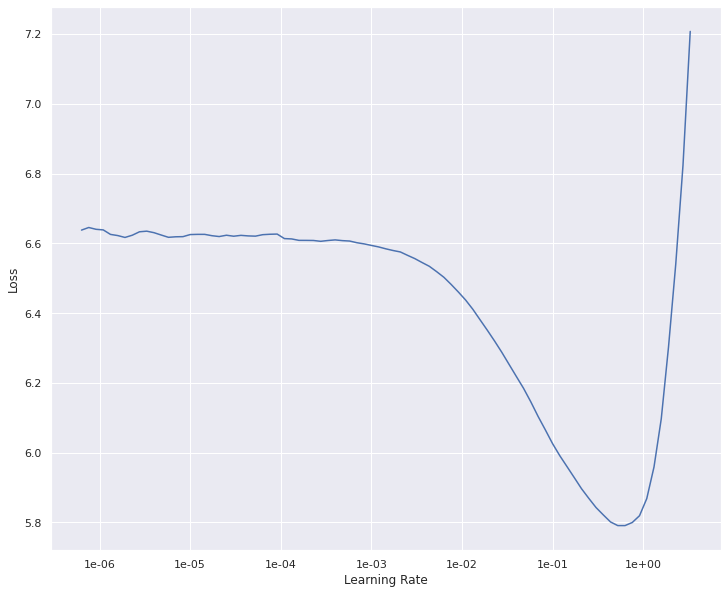

In [33]:
learn.recorder.plot()

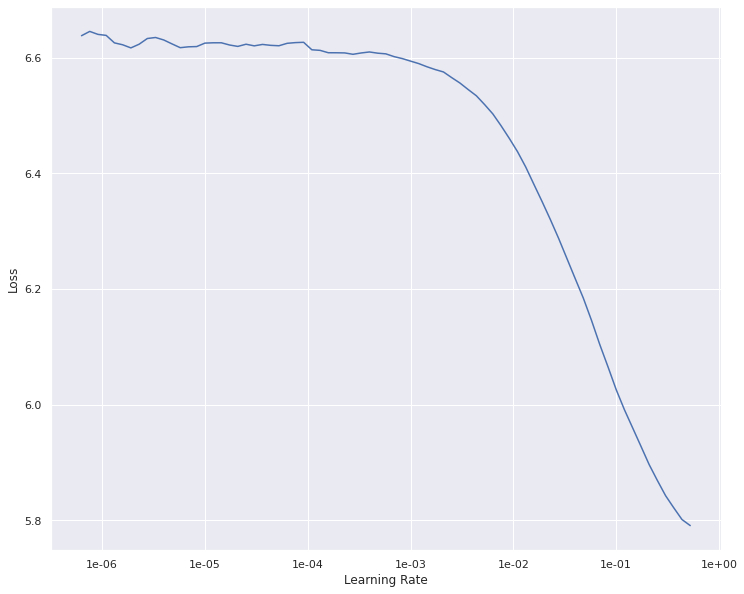

In [34]:
learn.recorder.plot(skip_end=15)

Now, we fit the model for a few cycles by running 1 epoch and then unfreezing and running subsequent epochs to fine tune the same.

In [35]:
moms = (0.8,0.7)
wd = 0.1
lr = 1.0E-02

In [36]:
learn.fit_one_cycle(1, lr, moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,4.670446,4.044089,0.271010,00:07


In [37]:
learn.unfreeze()

In [38]:
learn.fit_one_cycle(10,lr,moms = moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,3.885673,3.759860,0.306892,00:09
1,3.733045,3.758001,0.306111,00:09
2,3.599432,3.682565,0.313672,00:09
3,3.383517,3.689360,0.314118,00:09
4,3.147847,3.707607,0.313560,00:09
5,2.821116,3.747871,0.316099,00:09
6,2.409079,3.862793,0.315485,00:09
7,1.950973,4.015057,0.312500,00:09
8,1.580811,4.132882,0.310379,00:09
9,1.378906,4.172426,0.309403,00:09


After training the model for 10 epochs, we see that the accuracy of our model is very low, lets check the prediction on a custom input.

In [39]:
learn.predict("This airline is so bad! Never flying with them again!", n_words = 40)

'This airline is so bad! Never flying with them again! # unitedairlines # neveragain xxbos @jetblue how much longer to JFK employees get to know since your garbage causes delay of us . Outrageous xxbos @airline got it . Actually , we got it . xxbos @airline'

**The language model doesn't perform too well due to a variety of reasons -**
* As the tweets normally have no fixed format and include informal, often incorrect gramatical structures.
* Words in tweets often don't follow correct spellings and generic language conventions.
* As seen above, figures of speech like 'sarcasm' are difficult to account for.

In [40]:
learn.save_encoder('fine_tuned_enc')

## **Fine tuning our classifier**

Now we will repeat the process of creating and training a databrunch. Then train our LSTM language model all over again, but this time to predict the sentiments of the tweet and not just the word/words that follow.
This model architecture offers alot of advantage over its traditional language counterpart which uses the conventional bag of words representation for predictions.

**Splitting into test, train and validation sets**

In [41]:
train_valid, test = train_test_split(df_needed, test_size = 0.1)
train, valid = train_test_split(train_valid, test_size = 0.1) 

In [42]:
data_classifier = TextClasDataBunch.from_df(path, train_df = train, valid_df = valid, test_df = test, vocab = data.train_ds.vocab, text_cols = 'text', label_cols = 'airline_sentiment', bs = 24)

In [43]:
data_classifier.show_batch()

text,target
xxbos @airline i xxup just xxup asked xxup my xxup boyfriend xxup to xxup prom xxup over xxup the xxup xxunk xxup on xxup flight 494 xxup he xxup said xxup yes xxrep 4 ! xxup best xxup day xxup ever ! ! ! xxup thank u xxup so xxup much xxrep 6 !,positive
"xxbos @airline xxmaj waiting for 3494 xxup ewr - xxup ord , delayed 47 mins . xxmaj might miss xxunk xxup ord - xxup ywg at 6 pm xxup ct . xxmaj any room on xxunk xxup ord - xxup ywg in case i miss xxunk ?",negative
xxbos @airline xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive
"xxbos @airline our ft xxunk xxup xxunk / xxup dfw ( w / cx to xxup lga ) tomorrow xxmaj cancelled xxmaj flighted , 4 hrs so far waiting for call back . xxmaj what should we do ? xxmaj need to get to nyc",negative
"xxbos @airline yes , i am as well . * * xxup five * * xxup hours xxup on xxup hold , xxup folks . xxmaj can you xxup please tell me if this is typical ? ! xxmaj trying to be understanding here .",negative


In [44]:
learn = text_classifier_learner(data_classifier, AWD_LSTM, drop_mult = 0.5, model_dir = '/tmp/models')
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [45]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


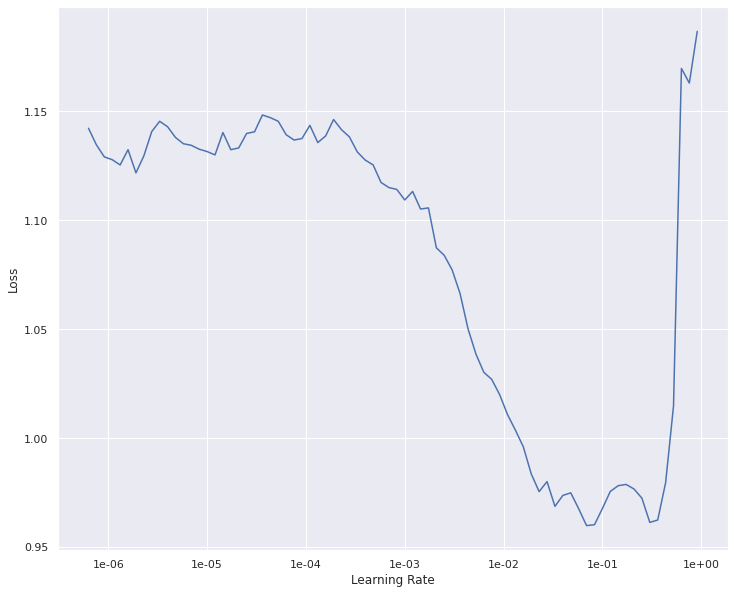

In [46]:
learn.recorder.plot()

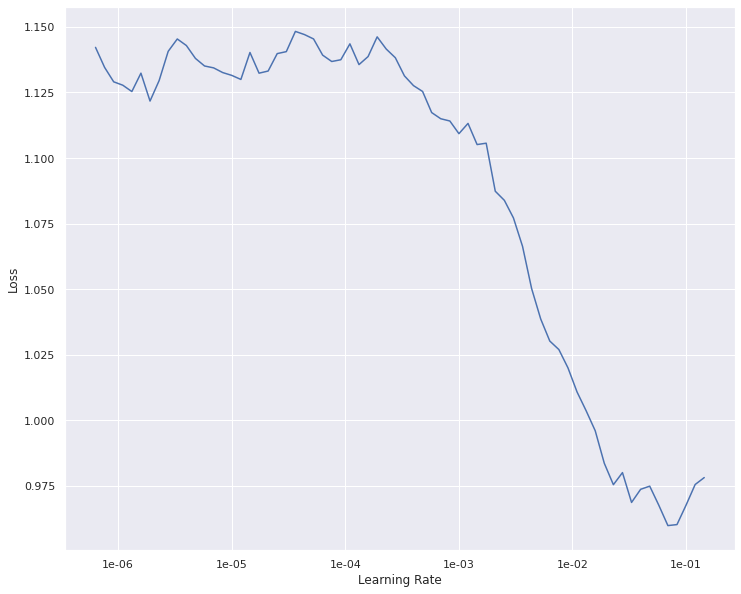

In [47]:
learn.recorder.plot(skip_end = 15)

**We train by gradually unfreezing layers and training our model one epoch at a time, in accordance to the suggestions in the fast.ai ULMFiT paper.**

In [48]:
lr = 1.0E-03
learn.fit_one_cycle(1,lr,moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.633960,0.582542,0.785281,00:08


In [49]:
learn.save('first')
#learn.load('first')

In [50]:
learn.freeze_to(-2)
lr/=2
learn.fit_one_cycle(1,slice(lr/(2.6*4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.600984,0.521983,0.789833,00:09


In [51]:
learn.save('second')
#learn.load('second')

In [52]:
learn.freeze_to(-3)
lr /=2
learn.fit_one_cycle(1,slice(lr/(2.6*4), lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.586606,0.525389,0.794385,00:14


In [53]:
learn.unfreeze()
lr /=5
learn.fit_one_cycle(3, slice(lr/(2.6**4),lr), moms=moms, wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,0.530167,0.507883,0.805008,00:19
1,0.542429,0.500299,0.801973,00:19
2,0.528971,0.512829,0.802731,00:19


Our model has now been trained, lets try to get a prediction for the same custom input we gave earlier.

In [54]:
learn.predict("This airline is so bad! Never flying with them again!")

(Category tensor(0), tensor(0), tensor([0.8103, 0.0110, 0.1787]))

We see that this model performs way better than our conventional language model. And hence we can now evaluate it's performance on the test set.

### Evaluate performance on test set.

In [56]:
print(test)

      airline_sentiment  \
2437   negative           
2255   negative           
12961  negative           
5176   positive           
7433   neutral            
...        ...            
4188   negative           
7946   neutral            
9740   negative           
11706  positive           
5177   negative           

                                                                                                                                             text  
2437   @airline What a really GREAT &amp; FLATTERING story about you! You should be very proud :) http://t.co/oKtUkjY92O (via @ParachuteGuy)       
2255   Reply to @airline - Doesn't do any good to check outlets preflight when moved to different equipment after boarding due to malfunction.     
12961  @airline the best is your 800 message saying to use website and your website is saying you need to call.  If you don't answer, #hardtodo    
5176   @airline Gate attendant at McCarran C16 (Vegas to Dallas) went above and bey

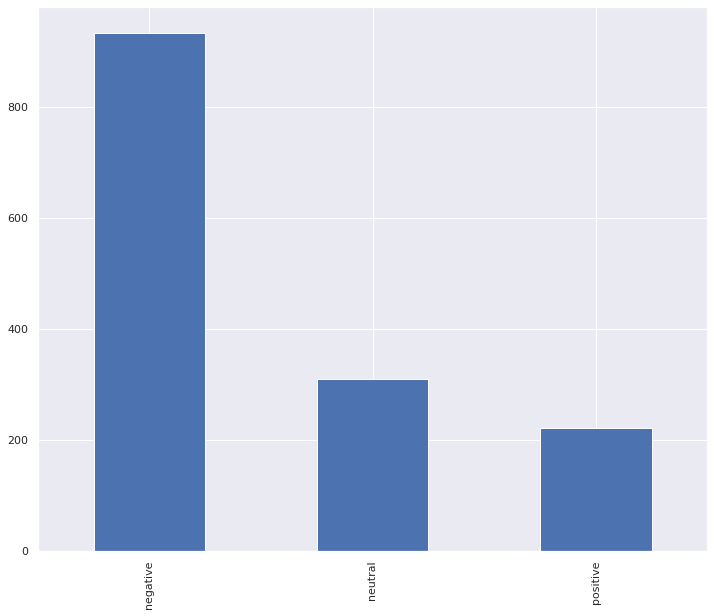

In [57]:
test['airline_sentiment'].value_counts().plot(kind='bar')

In [58]:
test['airline_sentiment'].value_counts()

negative    933
neutral     309
positive    222
Name: airline_sentiment, dtype: int64

**Predicting the sentiments of tweets in the test set**

In [59]:
test['predicted']=test['text'].apply(lambda row: str(learn.predict(row)[0]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [60]:
print(test)

      airline_sentiment  \
2437   negative           
2255   negative           
12961  negative           
5176   positive           
7433   neutral            
...        ...            
4188   negative           
7946   neutral            
9740   negative           
11706  positive           
5177   negative           

                                                                                                                                             text  \
2437   @airline What a really GREAT &amp; FLATTERING story about you! You should be very proud :) http://t.co/oKtUkjY92O (via @ParachuteGuy)        
2255   Reply to @airline - Doesn't do any good to check outlets preflight when moved to different equipment after boarding due to malfunction.      
12961  @airline the best is your 800 message saying to use website and your website is saying you need to call.  If you don't answer, #hardtodo     
5176   @airline Gate attendant at McCarran C16 (Vegas to Dallas) went above and

In [61]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464 entries, 2437 to 5177
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   airline_sentiment  1464 non-null   object
 1   text               1464 non-null   object
 2   predicted          1464 non-null   object
dtypes: object(3)
memory usage: 45.8+ KB


## **Evaluation**

Evaluation metric used - Accuracy
As the predicted sentiments would be either positive, negative or neutral, we can easily compare the predictions to the labels provided in the test set and check the number of times our model makes the correct prediction. 

In [62]:
print("Test Accuracy: ", accuracy_score(test['airline_sentiment'], test['predicted']))

Test Accuracy:  0.8224043715846995


**We see that our model gives us an accuracy of over 80% on the test set, which is quite good, considering the kind of data set and its anomalies.**

In [63]:
test.head(25)

,airline_sentiment,text,predicted
2437,negative,@airline What a really GREAT &amp; FLATTERING story about you! You should be very proud :) http://t.co/oKtUkjY92O (via @ParachuteGuy),positive
2255,negative,Reply to @airline - Doesn't do any good to check outlets preflight when moved to different equipment after boarding due to malfunction.,negative
12961,negative,"@airline the best is your 800 message saying to use website and your website is saying you need to call. If you don't answer, #hardtodo",negative
5176,positive,@airline Gate attendant at McCarran C16 (Vegas to Dallas) went above and beyond. After a long day of frustration it was welcome.,positive
7433,neutral,@JetBlue follow for DM please,neutral
4640,positive,@airline #netneutrality Nice to see you prioritize Internet traffic to your own streaming service over other web sites!,positive
584,negative,"@airline as a 1k, I'm always hoping for improvement.",positive
14001,positive,Thank you for sending more details @airline: They're pretty handy dandy. more info here: http://t.co/FvlxIRh1F1 #LookforwardtoflywithAA,neutral
749,negative,@airline plus what about food? And taxis?,neutral
4445,negative,@airline Adding RR number to a @Marriott stay is too hard. Won't take RR number at checkin/out and Marriott phone CS not helpful.,negative


**Now we plot the confusion matrix to see what the areas of misclassifiacation are and the reason for their existence.**

In [64]:
def plot_matrix(y_true, y_pred, classes, normalize = False, title = None, cmap=plt.cm.Blues):
    """
    This function plots the confusion matrix.
    Normalization can be applied by setting the Normalize parameter
    """
    
    if not title:
        if normalize:
            title = "Normalized Confusion Matrix"
        else:
            title='Not Normalized Confusion Matrix'
            
    confusion = confusion_matrix(y_true, y_pred)
    
    
    fig,ax = plt.subplots()
    im = ax.imshow(confusion, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    #display all ticks
    ax.set(xticks = np.arange(confusion.shape[1]),
          yticks = np.arange(confusion.shape[0]),
          xticklabels = classes, yticklabels = classes,
          title = title,
          ylabel = 'True Label',
          xlabel = 'Predicted Label')
    
    # display the count annotations by looping
    dtype = '.2f' if normalize else 'd'
    thresh = confusion.max() / 2.
    for i in range(confusion.shape[0]):
        for j in range(confusion.shape[1]):
            ax.text(j,i, format(confusion[i,j],dtype),
                   ha = 'center',va = 'center',
                   color = 'white' if confusion[i,j]> thresh else 'black')
    
    
    fig.tight_layout()
    return ax

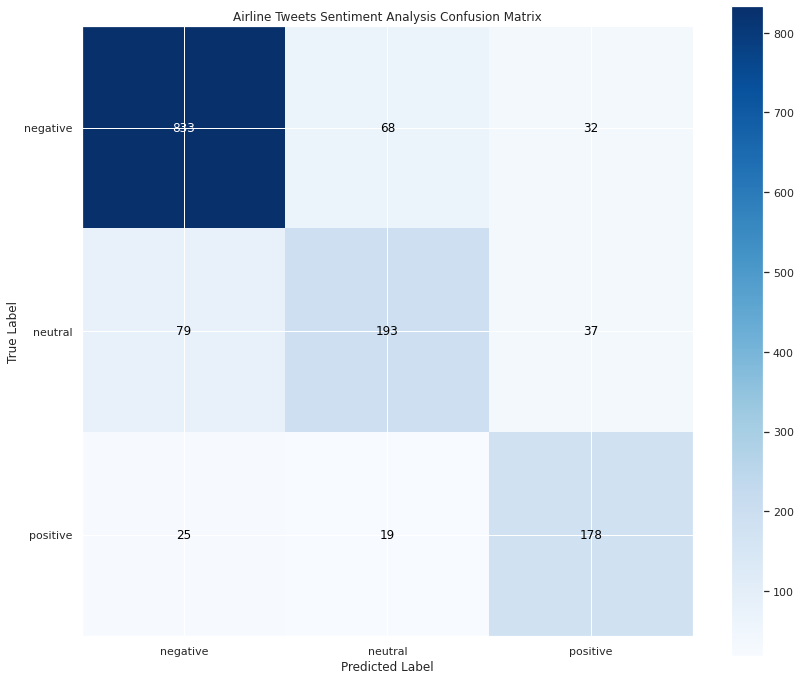

In [65]:
plot_matrix(test['airline_sentiment'], test['predicted'], classes=['negative','neutral','positive'], title = 'Airline Tweets Sentiment Analysis Confusion Matrix')
plt.show()

**True negatives - ** Have a very high prediction accuracy.
The model has a tough time classifying neutral tweets, often branding them as negative despite having an overall accuracy of over 80%.

But in our dataset, some of the tweets carry negative sentiment aimed at other twitter users instead of the airline. In addition, there are other things to consider with informal writing such as sarcasm, and improper gramatical structures that might en up confusing our model, leading to inaccurate predictions.

Moreover some of the negative tweets have been mislabelled in the dataset as neutral and vice versa, which can be another factor hampering the accuracy of our model.


The overall accuracy is good for true positives, but a vast majority of positive tweets get classified as negative. Lets look into them in more detail.

In [66]:
test.loc[(test['airline_sentiment']=='positive') & (test['predicted']=='negative')]

,airline_sentiment,text,predicted
14278,positive,@airline Thank you. Good suggestion. I checked and we were not rebooked. We'll keep checking and looking for other flights,negative
773,positive,"@airline flight ua3576, gate b1. And tell ray I somehow made it on to the 736 flight out of IAH and didn't have to wait for the 917 one. :)",negative
114,positive,@airline come back to #PHL already. We need you to take us out of this horrible cold. #pleasecomeback http://t.co/gLXFwP6nQH,negative
8057,positive,@JetBlue totally would have.... but the outside view was even more camera ready haha #EvenMoreSpace #EvenMoreView http://t.co/dXuX6DBfd3,negative
3664,positive,@airline thank you for getting our daughter home when @airline Cancelled Flightled all their flights to Nashville,negative
7719,positive,@JetBlue would you say a delay is more likely? Thanks so much.,negative
5666,positive,@airline shhhh i don't want something else to steal our deal😉,negative
6800,positive,@JetBlue here you go... Your napkins pretty much say it all! http://t.co/OxY1Jnpjm3,negative
3385,positive,@airline so sorry. I ended up on US Air flight. Thank you though for getting back to me:),negative
5468,positive,@airline Well plane arrived pretty much on time and it's 68 degrees on the ground in Texas. Not much to complain about.,negative


It cannot be immediately pointed out as to what the common thread was amidst all the above tweets that led to their misclassification, but possible causes could be gramatical errors, mis-spellings and deriving inacurate information from hashtags. 

### Conclusion and scope of improvement

In the future it could be a good idea to spend more time on feature engineering to account for improper grammatical structures and mis-spellings while fitting the language model, so that the model hence formulated is more suited to the vocabulary of the language used in informal writings like tweets. 

Even as humans, it is sometimes hard to judge the sentiment of a given tokenized piece of text and hence our model does a good job in predicting the labels with about 82% accuracy. 
One possible way of handling this issue could be to make use of a much larger corpus with maximum possible training examples that are likely to be encountered in tweets when developing the initial language model.

**Thankyou**


*****************************************